### Agent Function Call with Qwen2.5-VL

This notebook demonstrates how to use Qwen2.5-VL's agent function call capabilities to interact with a mobile device. It showcases the model's ability to generate and execute actions based on user queries and visual context.

#### \[Setup\] 

Load visualization utils.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen_agent
!pip install openai
!pip install icecream

In [27]:
## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
import os
os.environ['DASHSCOPE_API_KEY'] = "your api key"

In [4]:
import os.path as osp
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from icecream import ic
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

def draw_point(image: Image.Image, point: list, color=None):
    from copy import deepcopy
    if isinstance(color, str):
        try:
            color = ImageColor.getrgb(color)
            color = color + (128,)  
        except ValueError:
            color = (255, 0, 0, 128)  
    else:
        color = (255, 0, 0, 128)  
 
    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    radius = min(image.size) * 0.05
    x, y = point

    overlay_draw.ellipse(
        [(x - radius, y - radius), (x + radius, y + radius)],
        fill=color  # Red with 50% opacity
    )

    image = image.convert('RGBA')
    combined = Image.alpha_composite(image, overlay)

    return combined.convert('RGB')

Load model and processors.

In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model_path = "/mnt/cpfs_m6_29eu38p1/data/shared/public/baishuai/ckpt_important/qwen2.5vl/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


#### 1. Mobile Use

##### [Example] English App & Query

text <|im_start|>system
You are a helpful assistant.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name_for_human": "mobile_use", "name": "mobile_use", "description": "Use a touchscreen to interact with a mobile device, and take screenshots.\n* This is an interface to a mobile device with touchscreen. You can perform actions like clicking, typing, swiping, etc.\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions.\n* The screen's resolution is 1092x2408.\n* Make sure to click any buttons, links, icons, etc with the cursor tip in the center of the element. Don't click boxes on their edges unless asked.", "parameters": {"properties": {"action": {"description": "The action to perform. The available actions are:\n* `key`: Perform a key event o

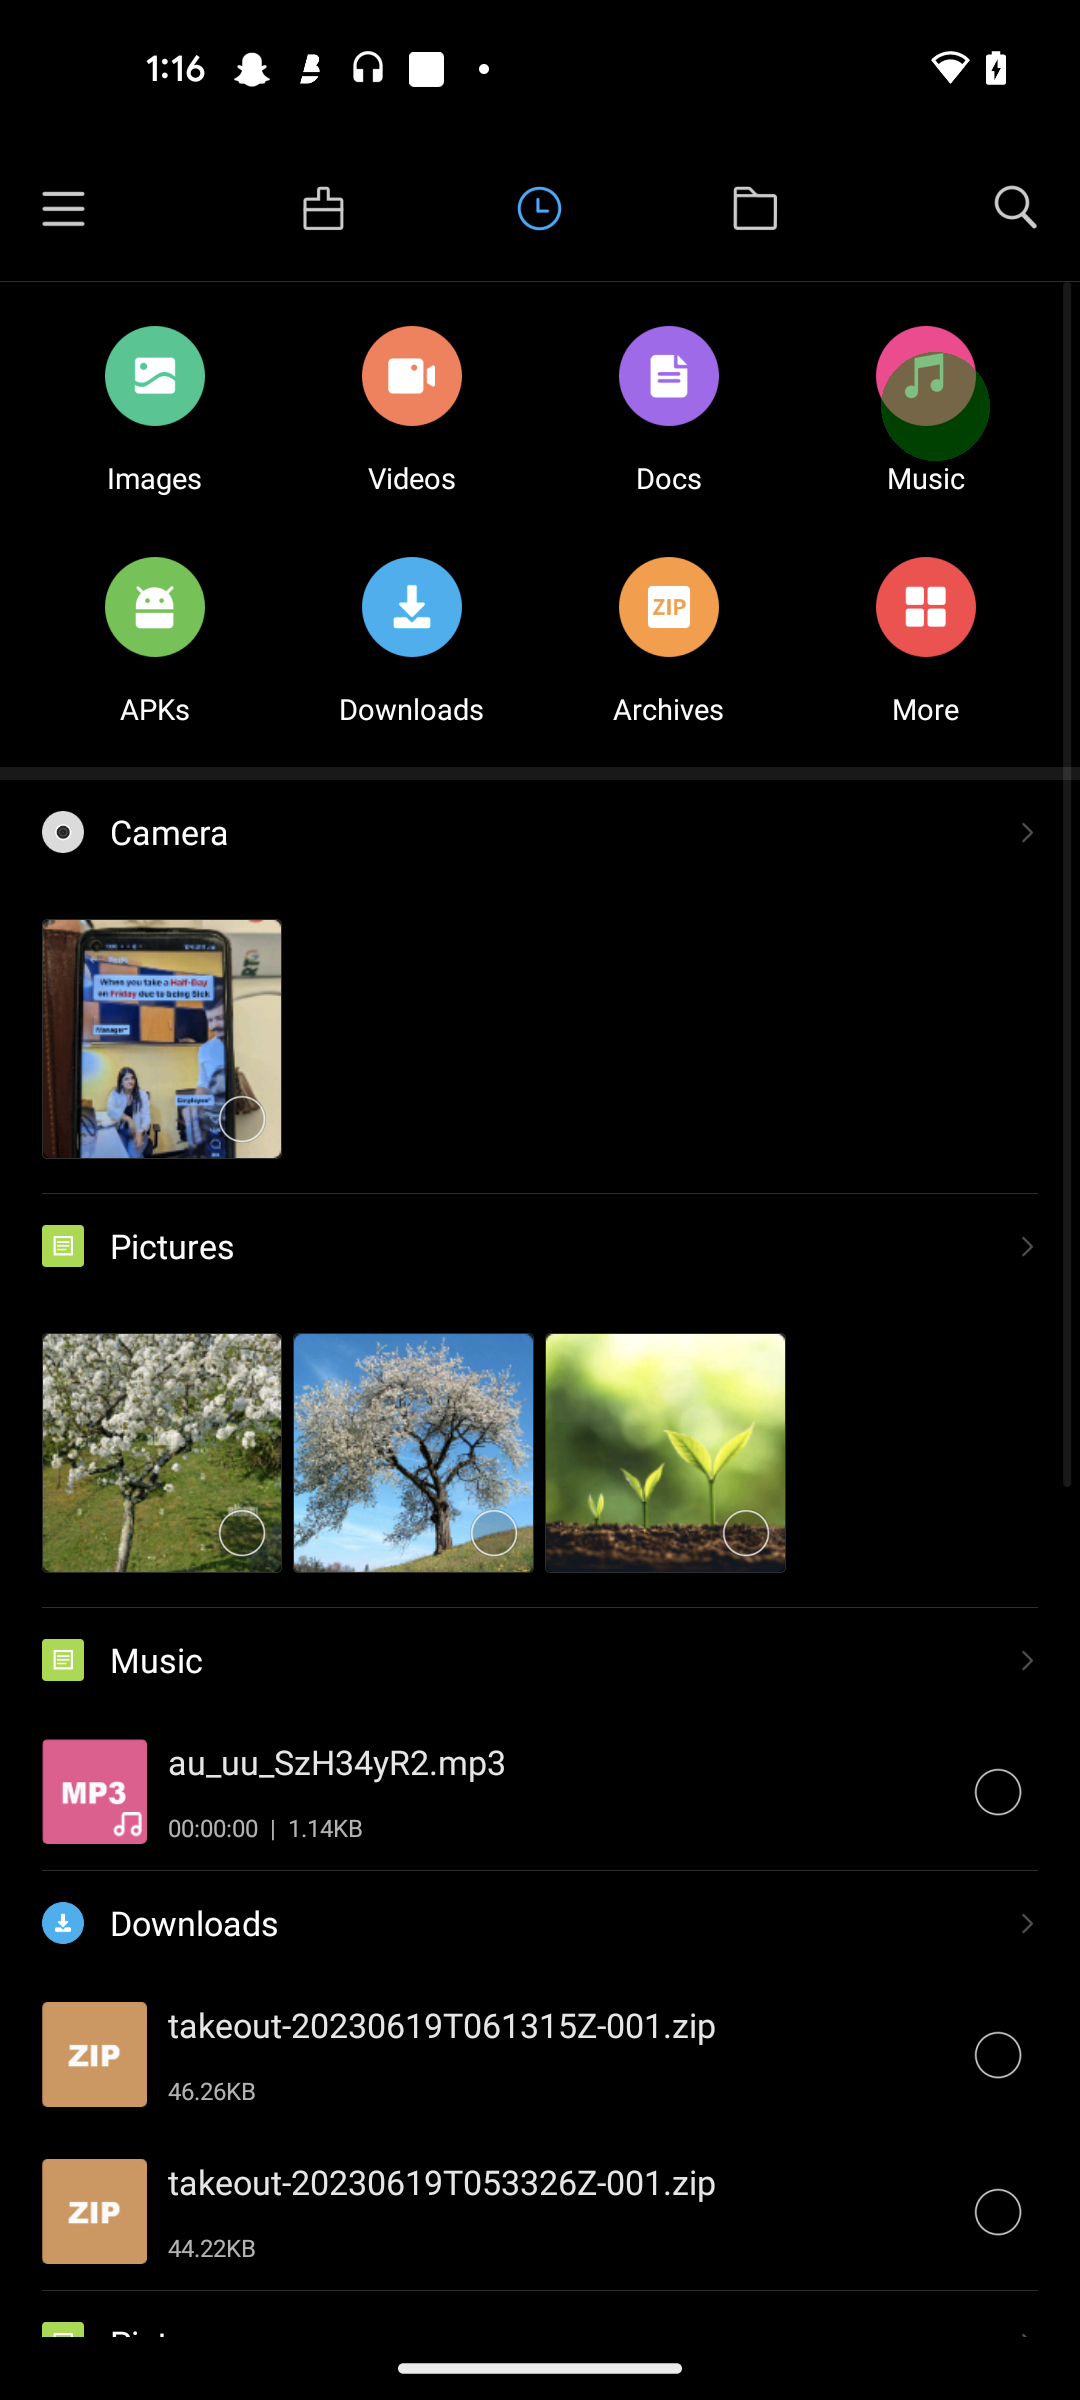

In [7]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display


# Prapare your screenshot file and global query

screenshot = "./assets/agent_function_call/mobile_en_example.png"

# The operation history can be orgnized by Step x: [action]; Step x+1: [action]...
user_query = 'The user query:  Open the file manager app and view the au_uu_SzH3yR2.mp3 file in MUSIC Folder\nTask progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; '

# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,)
mobile_use = MobileUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
)

# Build messages
message = NousFnCallPrompt.preprocess_fncall_messages(
    messages = [
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
        Message(role="user", content=[
            ContentItem(text=user_query),
            ContentItem(image=f"file://{screenshot}")
        ]),
    ],
    functions=[mobile_use.function],
    lang=None,
)
message = [msg.model_dump() for msg in message]

text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
print("text",text)
inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')


output_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
print(output_text)

# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
display_image = dummy_image.resize((resized_width, resized_height))
if action['arguments']['action'] == "click":
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(display_image)
else:
    display(display_image)

##### [Example] English App & Query with API

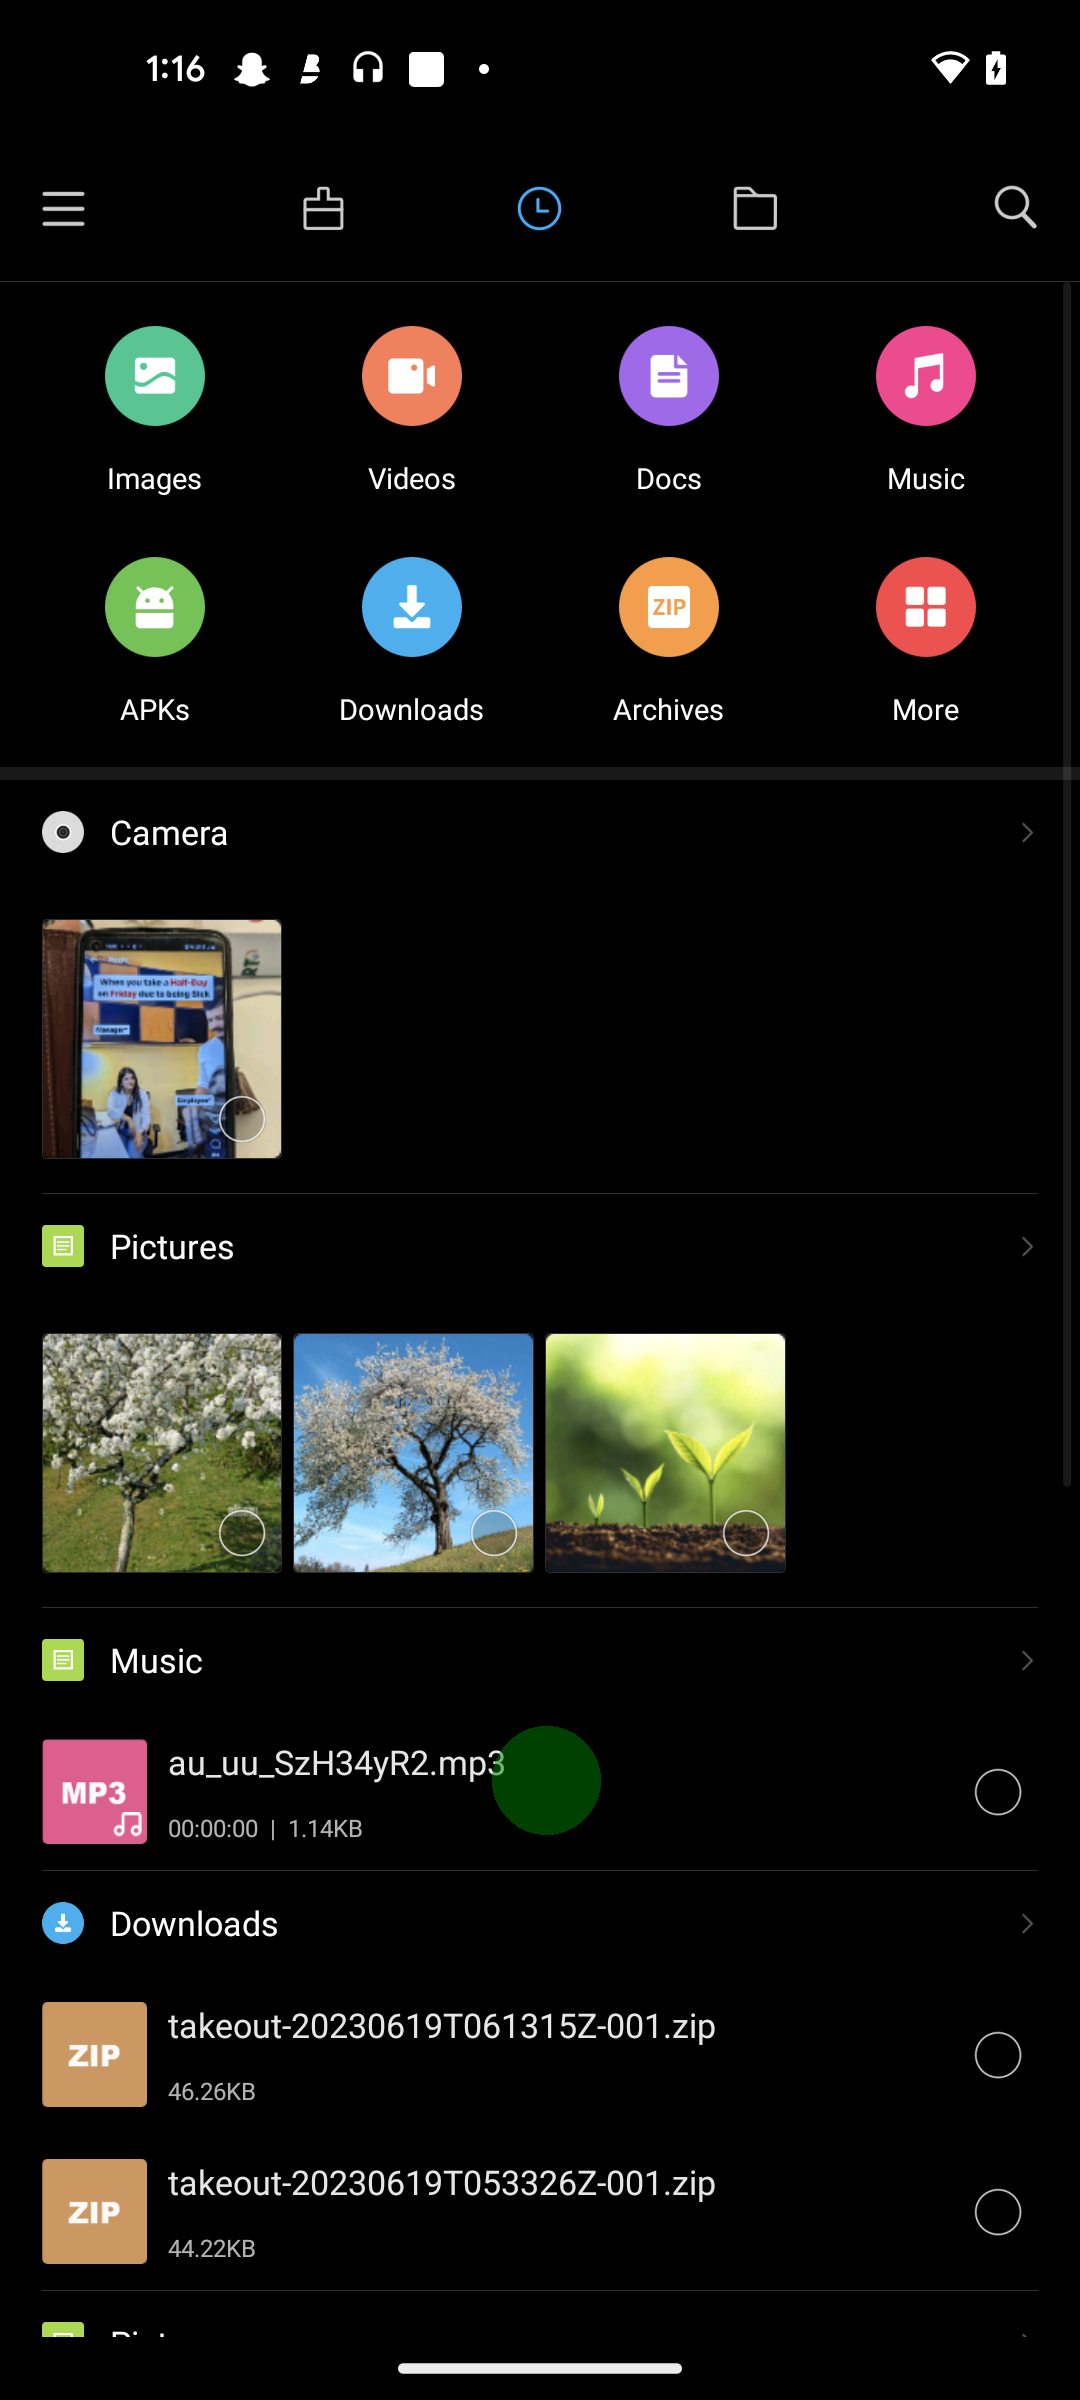

In [25]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
from openai import OpenAI

# Prapare your screenshot file and global query

model_id="qwen2.5-vl-7b-instruct"

screenshot = "./assets/agent_function_call/mobile_en_example.png"

# The operation history can be orgnized by Step x: [action]; Step x+1: [action]...
user_query = 'The user query:  Open the file manager app and view the au_uu_SzH3yR2.mp3 file in MUSIC Folder\nTask progress (You have done the following operation on the current device): Step 1: {"name": "mobile_use", "arguments": {"action": "open", "text": "File Manager"}}; '

client = OpenAI(
    #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
    api_key=os.getenv('DASHSCOPE_API_KEY'),
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
)

# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,)
mobile_use = MobileUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
)


base64_image = encode_image(screenshot)
# Build messages

system_message = NousFnCallPrompt.preprocess_fncall_messages(
    messages=[
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
    ],
    functions=[mobile_use.function],
    lang=None,
)

system_message = system_message[0].model_dump()
messages=[
    {
        "role": "system",
        "content": [
            {"type": "text", "text": msg["text"]} for msg in system_message["content"]
        ],
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "min_pixels": processor.image_processor.min_pixels,
                "max_pixels": processor.image_processor.max_pixels,
                # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                # PNG image:  f"data:image/png;base64,{base64_image}"
                # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                # WEBP image: f"data:image/webp;base64,{base64_image}"
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
            {"type": "text", "text": user_query},
        ],
    }
]
# print(json.dumps(messages, indent=4))
completion = client.chat.completions.create(
    model = model_id,
    messages = messages,

)

output_text = completion.choices[0].message.content

# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
display_image = dummy_image.resize((resized_width, resized_height))
if action['arguments']['action'] == "click":
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(display_image)
else:
    display(display_image)

##### [Example] Chinese App & Query

text <|im_start|>system
You are a helpful assistant.

# Tools

You may call one or more functions to assist with the user query.

You are provided with function signatures within <tools></tools> XML tags:
<tools>
{"type": "function", "function": {"name_for_human": "mobile_use", "name": "mobile_use", "description": "Use a touchscreen to interact with a mobile device, and take screenshots.\n* This is an interface to a mobile device with touchscreen. You can perform actions like clicking, typing, swiping, etc.\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions.\n* The screen's resolution is 728x1288.\n* Make sure to click any buttons, links, icons, etc with the cursor tip in the center of the element. Don't click boxes on their edges unless asked.", "parameters": {"properties": {"action": {"description": "The action to perform. The available actions are:\n* `key`: Perform a key event on

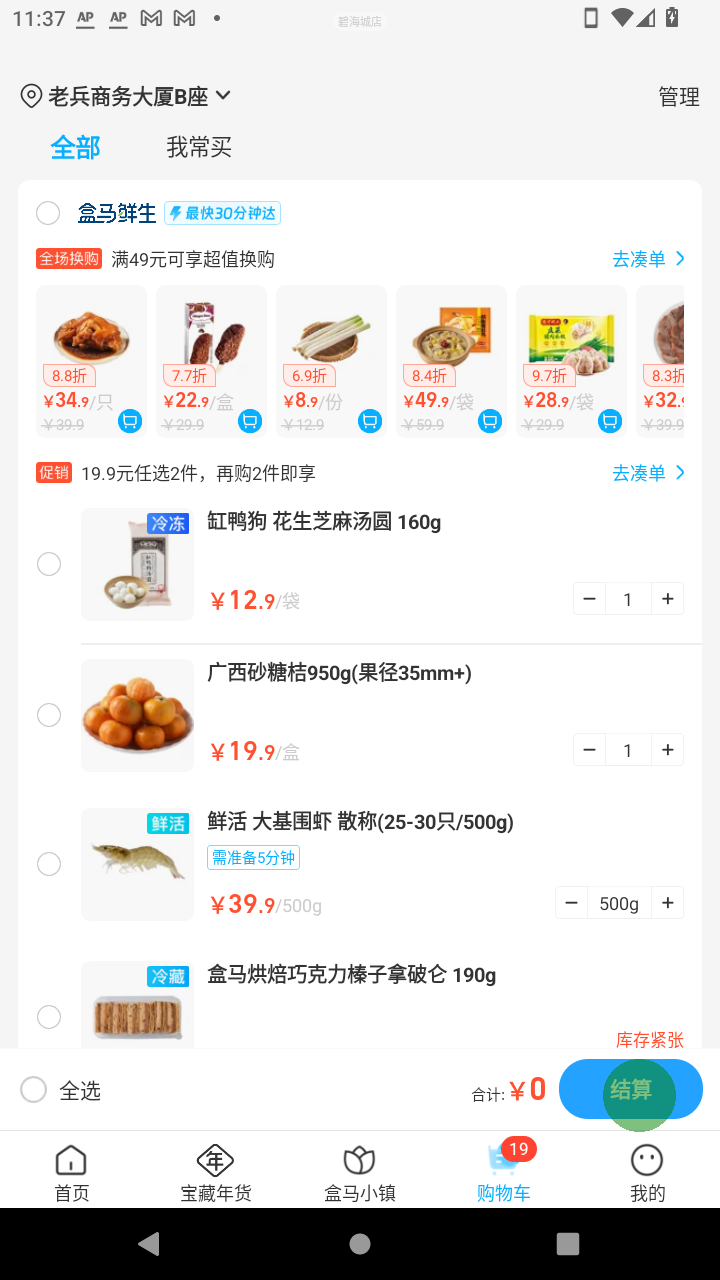

In [8]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display


# Prapare your screenshot file and global query

screenshot = "assets/agent_function_call/mobile_zh_example.jpg"

# You can also start from an intermediate screenshot without passing in the history.
user_query = 'The user query:在盒马中,打开购物车，结算（到付款页面即可） (You have done the following operation on the current device):'


# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,)
mobile_use = MobileUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
)

# Build messages
message = NousFnCallPrompt.preprocess_fncall_messages(
    messages = [
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
        Message(role="user", content=[
            ContentItem(text=user_query),
            ContentItem(image=f"file://{screenshot}")
        ]),
    ],
    functions=[mobile_use.function],
    lang=None,
)
message = [msg.model_dump() for msg in message]

text = processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
print("text",text)
inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')


output_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
print(output_text)

# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
display_image = dummy_image.resize((resized_width, resized_height))
if action['arguments']['action'] == "click":
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(display_image)
else:
    display(display_image)

##### [Example] Chinese App & Query with API

<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [639, 1095]}}
</tool_call>


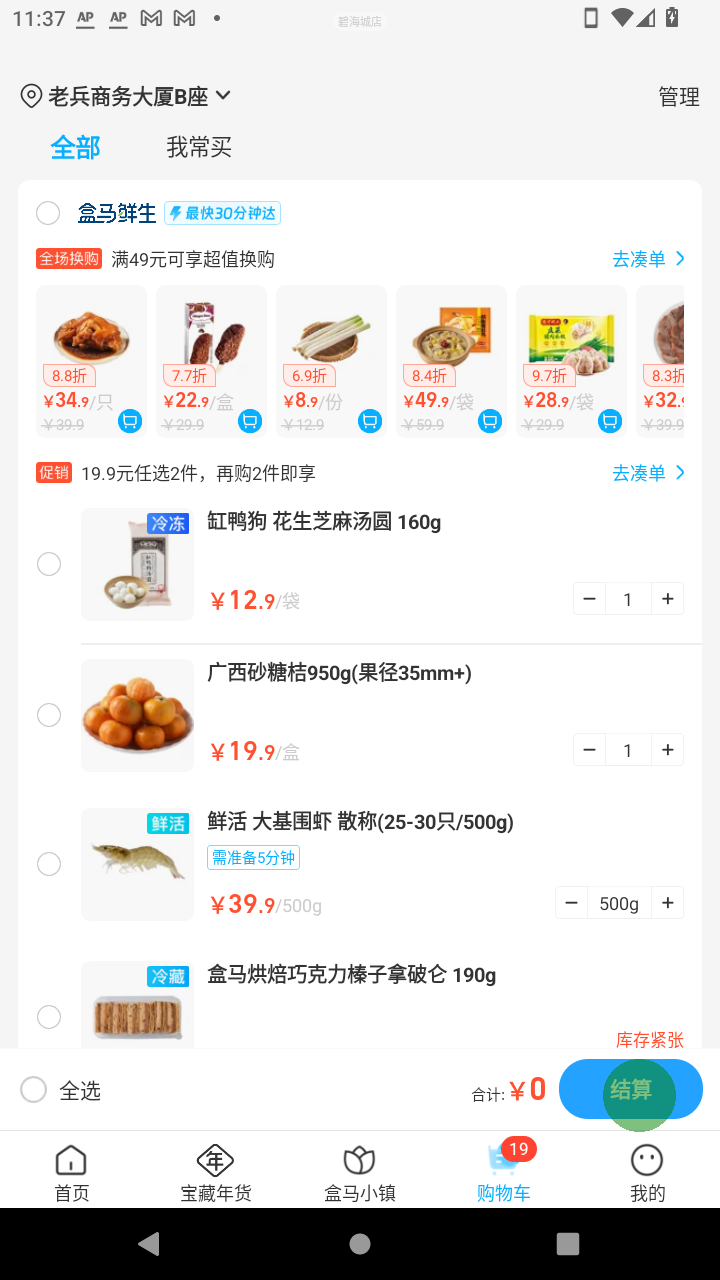

In [26]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display


model_id="qwen2.5-vl-7b-instruct"
# Prapare your screenshot file and global query

screenshot = "assets/agent_function_call/mobile_zh_example.jpg"

# You can also start from an intermediate screenshot without passing in the history.
user_query = 'The user query:在盒马中,打开购物车，结算（到付款页面即可） (You have done the following operation on the current device):'


# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=processor.image_processor.patch_size * processor.image_processor.merge_size,
    min_pixels=processor.image_processor.min_pixels,
    max_pixels=processor.image_processor.max_pixels,)
mobile_use = MobileUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
)


base64_image = encode_image(screenshot)
# Build messages

system_message = NousFnCallPrompt.preprocess_fncall_messages(
    messages=[
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")]),
    ],
    functions=[mobile_use.function],
    lang=None,
)

system_message = system_message[0].model_dump()
messages=[
    {
        "role": "system",
        "content": [
            {"type": "text", "text": msg["text"]} for msg in system_message["content"]
        ],
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "min_pixels": processor.image_processor.min_pixels,
                "max_pixels": processor.image_processor.max_pixels,
                # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                # PNG image:  f"data:image/png;base64,{base64_image}"
                # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                # WEBP image: f"data:image/webp;base64,{base64_image}"
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
            {"type": "text", "text": user_query},
        ],
    }
]
# print(json.dumps(messages, indent=4))
completion = client.chat.completions.create(
    model = model_id,
    messages = messages,

)

output_text = completion.choices[0].message.content
inputs = processor(text=[text], images=[dummy_image], padding=True, return_tensors="pt").to('cuda')


output_ids = model.generate(**inputs, max_new_tokens=2048)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
print(output_text)

# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
display_image = dummy_image.resize((resized_width, resized_height))
if action['arguments']['action'] == "click":
    display_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(display_image)
else:
    display(display_image)